## 1. Scala's real-world project repository data
<p>With almost 30k commits and a history spanning over ten years, Scala is a mature programming language. It is a general-purpose programming language that has recently become another prominent language for data scientists.</p>
<p>Scala is also an open source project. Open source projects have the advantage that their entire development histories -- who made changes, what was changed, code reviews, etc. -- are publicly available. </p>
<p>We're going to read in, clean up, and visualize the real world project repository of Scala that spans data from a version control system (Git) as well as a project hosting site (GitHub). We will find out who has had the most influence on its development and who are the experts.</p>
<p>The dataset we will use, which has been previously mined and extracted from GitHub, is comprised of three files:</p>
<ol>
<li><code>pulls_2011-2013.csv</code> contains the basic information about the pull requests, and spans from the end of 2011 up to (but not including) 2014.</li>
<li><code>pulls_2014-2018.csv</code> contains identical information, and spans from 2014 up to 2018.</li>
<li><code>pull_files.csv</code> contains the files that were modified by each pull request.</li>
</ol>

In [636]:
# Import libraries
import pandas as pd
import datetime as dt

# Load in the data
pulls_one = pd.read_csv("datasets/pulls_2011-2013.csv")
pulls_two = pd.read_csv("datasets/pulls_2014-2018.csv")
pull_files = pd.read_csv("datasets/pull_files.csv") 

In [637]:
# Preview and check that it loaded properly
pulls_one.head()

,pid,user,date
0,11166973,VladimirNik,2013-12-31T23:10:55Z
1,11161892,Ichoran,2013-12-31T16:55:47Z
2,11153894,Ichoran,2013-12-31T02:41:13Z
3,11151917,rklaehn,2013-12-30T23:45:47Z
4,11131244,qerub,2013-12-29T17:21:01Z


In [639]:
pulls_two.head()

,pid,user,date
0,163314316,hrhino,2018-01-16T23:29:16Z
1,163061502,joroKr21,2018-01-15T23:44:52Z
2,163057333,mkeskells,2018-01-15T23:05:06Z
3,162985594,lrytz,2018-01-15T15:52:39Z
4,162838837,zuvizudar,2018-01-14T19:16:16Z


In [640]:
pull_files.head()

,pid,file
0,163314316,test/files/pos/t5638/Among.java
1,163314316,test/files/pos/t5638/Usage.scala
2,163314316,test/files/pos/t9291.scala
3,163314316,test/files/run/t8348.check
4,163314316,test/files/run/t8348/TableColumn.java


## 2. Preparing and cleaning the data
<p>First, we will need to combine the data from the two separate pull DataFrames. </p>
<p>Next, the raw data extracted from GitHub contains dates in the ISO8601 format. However, <code>pandas</code> imports them as regular strings. To make our analysis easier, we need to convert the strings into Python's <code>DateTime</code> objects. <code>DateTime</code> objects have the important property that they can be compared and sorted.</p>
<p>The pull request times are all in UTC (also known as Coordinated Universal Time). The commit times, however, are in the local time of the author with time zone information (number of hours difference from UTC). To make comparisons easy, we should convert all times to UTC.</p>

In [641]:
# Append pulls_one to pulls_two
pulls = pd.concat([pulls_one, pulls_two])

# Reset index
pulls.reset_index()

# Info
pulls.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6200 entries, 0 to 2903
Data columns (total 3 columns):
pid     6200 non-null int64
user    6200 non-null object
date    6200 non-null object
dtypes: int64(1), object(2)
memory usage: 193.8+ KB


In [642]:
# Convert date for the pulls object
# Then check
pulls["date"] = pd.to_datetime(pulls["date"], utc=True)
pulls.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6200 entries, 0 to 2903
Data columns (total 3 columns):
pid     6200 non-null int64
user    6200 non-null object
date    6200 non-null datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1), int64(1), object(1)
memory usage: 193.8+ KB


## 3. Merging the DataFrames
<p>The data extracted comes in two separate files. Merging the two DataFrames will make it easier for us to analyze the data in the future tasks.</p>

In [644]:
# Examine pulls
pulls.head()

,pid,user,date
0,11166973,VladimirNik,2013-12-31 23:10:55+00:00
1,11161892,Ichoran,2013-12-31 16:55:47+00:00
2,11153894,Ichoran,2013-12-31 02:41:13+00:00
3,11151917,rklaehn,2013-12-30 23:45:47+00:00
4,11131244,qerub,2013-12-29 17:21:01+00:00


In [645]:
# Examine pull_files
pull_files.head()

,pid,file
0,163314316,test/files/pos/t5638/Among.java
1,163314316,test/files/pos/t5638/Usage.scala
2,163314316,test/files/pos/t9291.scala
3,163314316,test/files/run/t8348.check
4,163314316,test/files/run/t8348/TableColumn.java


In [646]:
# Merge the two DataFrames on pid
data = pulls.merge(pull_files, on = "pid")

# Check
data.head()

,pid,user,date,file
0,11166973,VladimirNik,2013-12-31 23:10:55+00:00,src/reflect/scala/reflect/api/Printers.scala
1,11166973,VladimirNik,2013-12-31 23:10:55+00:00,src/reflect/scala/reflect/internal/Printers.scala
2,11166973,VladimirNik,2013-12-31 23:10:55+00:00,test/files/run/reify_ann3.check
3,11166973,VladimirNik,2013-12-31 23:10:55+00:00,test/junit/scala/reflect/internal/PrintersTest...
4,11161892,Ichoran,2013-12-31 16:55:47+00:00,src/library/scala/collection/mutable/ArrayOps....


## 4. Is the project still actively maintained?
<p>The activity in an open source project is not very consistent. Some projects might be active for many years after the initial release, while others can slowly taper out into oblivion. Before committing to contributing to a project, it is important to understand the state of the project. Is development going steadily, or is there a drop? Has the project been abandoned altogether?</p>
<p>The data used in this project was collected in January of 2018. We are interested in the evolution of the number of contributions up to that date.</p>
<p>For Scala, we will do this by plotting a chart of the project's activity. We will calculate the number of pull requests submitted each (calendar) month during the project's lifetime. We will then plot these numbers to see the trend of contributions.</p>
<ul>
<li><p>A helpful reminder of how to access various components of a date can be found in <a href="https://campus.datacamp.com/courses/data-manipulation-with-pandas/slicing-and-indexing?ex=12">this exercise of Data Manipulation with pandas</a></p></li>
<li><p>Additionally, recall that you can group by multiple variables by passing a list to <code>groupby()</code>. This video from <a href="https://campus.datacamp.com/courses/data-manipulation-with-pandas/aggregating-data-ad6d4643-0e95-470c-8299-f69cc4c83de8?ex=9">Data Manipulation with pandas</a> should help!</p></li>
</ul>

year  month
2011  12        590
2012  1         489
      2         787
      3         880
      4        3354
Name: pid, dtype: int64


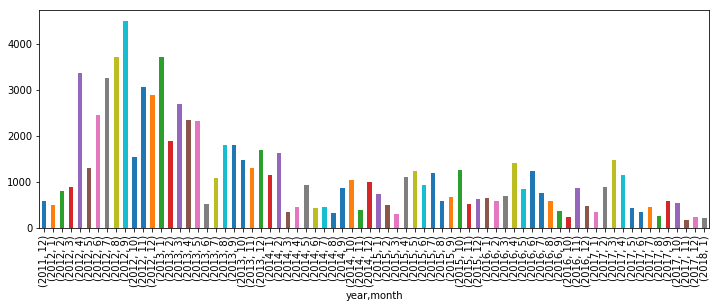

In [648]:
%matplotlib inline

# Create a column that will store the month
data["month"] = data["date"].dt.month

# Create a column that will store the year
data["year"] = data["date"].dt.year

# Group by the month and year and count the pull requests
counts = data.groupby(["year", "month"]).count()["pid"]

# Check
print(counts.head())

# Plot the results
counts.plot(kind="bar", figsize = (12,4))

## 5. Is there camaraderie in the project?
<p>The organizational structure varies from one project to another, and it can influence your success as a contributor. A project that has a very small community might not be the best one to start working on. The small community might indicate a high barrier of entry. This can be caused by several factors, including a community that is reluctant to accept pull requests from "outsiders," that the code base is hard to work with, etc. However, a large community can serve as an indicator that the project is regularly accepting pull requests from new contributors. Such a project would be a good place to start.</p>
<p>In order to evaluate the dynamics of the community, we will plot a histogram of the number of pull requests submitted by each user. A distribution that shows that there are few people that only contribute a small number of pull requests can be used as in indicator that the project is not welcoming of new contributors. </p>

user
0xmohit           2
193s              4
2m               20
4.00E+06         22
AlexeyIvanov8     2
Name: pid, dtype: int64


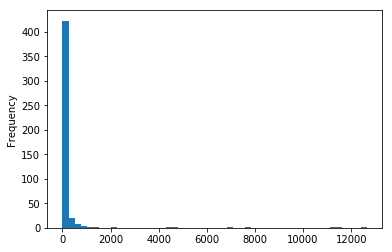

In [650]:
# Required for matplotlib
%matplotlib inline

# Group by the submitter
by_user = data.groupby("user").count().pid

# Check
print(by_user.head())

# Plot histogram
by_user.plot(kind="hist", bins=50)

## 6. What files were changed in the last ten pull requests?
<p>Choosing the right place to make a contribution is as important as choosing the project to contribute to. Some parts of the code might be stable, some might be dead. Contributing there might not have the most impact. Therefore it is important to understand the parts of the system that have been recently changed. This allows us to pinpoint the "hot" areas of the code where most of the activity is happening. Focusing on those parts might not the most effective use of our times.</p>

In [652]:
# Identify the last 10 pull requests.
# Since DateTimes are comparable,
# the largest 10 dates are also the 
# most recent ones
last_10 = pulls.nlargest(10, "date")

# Check
print(last_10)

# Join the two data sets
joined_pr = last_10.merge(pull_files, on="pid")

# Identify the unique files
files = set(joined_pr["file"])

# Print the results
files

         pid         user                      date
0  163314316       hrhino 2018-01-16 23:29:16+00:00
1  163061502     joroKr21 2018-01-15 23:44:52+00:00
2  163057333    mkeskells 2018-01-15 23:05:06+00:00
3  162985594        lrytz 2018-01-15 15:52:39+00:00
4  162838837    zuvizudar 2018-01-14 19:16:16+00:00
5  162765232  howtonotwin 2018-01-13 04:37:17+00:00
6  162643301       hrhino 2018-01-12 14:29:49+00:00
7  162256029    mkeskells 2018-01-10 23:20:03+00:00
8  162197834    SethTisue 2018-01-10 18:31:25+00:00
9  162011899     joroKr21 2018-01-10 00:45:57+00:00


{'LICENSE',
 'doc/LICENSE.md',
 'doc/License.rtf',
 'project/VersionUtil.scala',
 'src/compiler/scala/reflect/reify/phases/Calculate.scala',
 'src/compiler/scala/tools/nsc/backend/jvm/BCodeHelpers.scala',
 'src/compiler/scala/tools/nsc/backend/jvm/PostProcessor.scala',
 'src/compiler/scala/tools/nsc/backend/jvm/analysis/BackendUtils.scala',
 'src/compiler/scala/tools/nsc/profile/AsyncHelper.scala',
 'src/compiler/scala/tools/nsc/profile/Profiler.scala',
 'src/compiler/scala/tools/nsc/symtab/classfile/ClassfileParser.scala',
 'src/compiler/scala/tools/nsc/typechecker/Contexts.scala',
 'src/library/scala/Predef.scala',
 'src/library/scala/concurrent/Lock.scala',
 'src/library/scala/util/Properties.scala',
 'src/reflect/scala/reflect/internal/pickling/ByteCodecs.scala',
 'src/reflect/scala/reflect/internal/tpe/GlbLubs.scala',
 'src/scaladoc/scala/tools/nsc/doc/html/page/Entity.scala',
 'src/scalap/decoder.properties',
 'test/files/neg/leibniz-liskov.check',
 'test/files/neg/leibniz-liskov

## 7. Who made the most pull requests to a given file?
<p>When contributing to a project, we might need some guidance. We might find ourselves needing some information regarding the codebase. It is important direct any questions to the right person. Contributors to open source projects generally have other day jobs, so their time is limited. It is important to address our questions to the right people. One way to identify the right target for our inquiries is by using their contribution history.</p>
<p>We identified <code>src/compiler/scala/reflect/reify/phases/Calculate.scala</code> as being recently changed. We are interested in the top 3 developers who changed that file. Those developers are the ones most likely to have the best understanding of the code.</p>

In [654]:
# This is the file we are interested in:
file = "src/compiler/scala/reflect/reify/phases/Calculate.scala"

# Identify the pull requests that changed the file
file_pr = data[data["file"] == file]

# Count the number of changes made by each developer
author_counts = file_pr.groupby("user").count().file

# Print the top 3 developers
author_counts.nlargest(3)

user
xeno-by     11
retronym     5
soc          4
Name: file, dtype: int64

## 8. Who made the last ten pull requests on a given file?
<p>Open source projects suffer from fluctuating membership. This makes the problem of finding the right person more challenging: the person has to be knowledgeable <em>and</em> still be involved in the project. A person that contributed a lot in the past might no longer be available (or willing) to help. To get a better understanding, we need to investigate the more recent history of that particular part of the system. </p>
<p>Like in the previous task, we will look at the history of  <code>src/compiler/scala/reflect/reify/phases/Calculate.scala</code>.</p>

In [656]:
file = "src/compiler/scala/reflect/reify/phases/Calculate.scala"

# Select the pull requests that changed the target file
file_pr = pull_files[pull_files["file"] == file]

# Merge the obtained results with the pulls DataFrame
joined_pr = file_pr.merge(pulls, on="pid")

# Find the users of the last 10 most recent pull requests
users_last_10 = joined_pr.nlargest(10, "date").user.unique()

# Printing the results
print(users_last_10)

['zuvizudar' 'retronym' 'xeno-by' 'soc' 'bjornregnell' 'starblood']


## 9. The pull requests of two special developers
<p>Now that we have identified two potential contacts in the projects, we need to find the person who was most involved in the project in recent times. That person is most likely to answer our questions. For each calendar year, we are interested in understanding the number of pull requests the authors submitted. This will give us a high-level image of their contribution trend to the project.</p>

         pid     user                      date
7   11126653  xeno-by 2013-12-28 19:39:23+00:00
9   11121557  xeno-by 2013-12-27 23:50:56+00:00
10  11121465  xeno-by 2013-12-27 23:41:05+00:00
11  11121327  xeno-by 2013-12-27 23:25:52+00:00
12  11114584  xeno-by 2013-12-27 15:51:50+00:00

 user  soc  xeno-by
year              
2011   12       20
2012   44      271
2013  117      123
2014   20       60
2015   24        3
2016   21        0


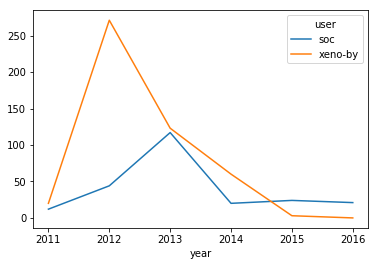

In [658]:
%matplotlib inline

# The developers we are interested in
authors = ["xeno-by", "soc"]

# Get all the developers' pull requests
by_author = pulls[pulls["user"].isin(authors)]

# Check
print(by_author.head())

# Convert date to datetime year
by_author["year"] = pd.to_datetime(by_author["date"]).dt.year

# Drop date column and check
by_author = by_author.drop(["date"], axis=1)

# Count the number of pull requests submitted each year
counts = by_author.groupby(["user", "year"]).agg({'pid': 'count'})

# Reset index
counts.reset_index()
counts

# Convert the table to a wide format
# Fill missing values with 0
counts_wide = counts.pivot_table(index='year', columns='user', values='pid', fill_value=0)

# Check
print("\n", counts_wide)

# Plot the results
counts_wide.plot()

## 10. Visualizing the contributions of each developer
<p>As mentioned before, it is important to make a distinction between the global expertise and contribution levels and the contribution levels at a more granular level (file, submodule, etc.) In our case, we want to see which of our two developers of interest have the most experience with the code in a given file. We will measure experience by the number of pull requests submitted that affect that file and how recent those pull requests were submitted.</p>

user  soc  xeno-by
date              
2012    2       10
2013    2        0
2014    0        1


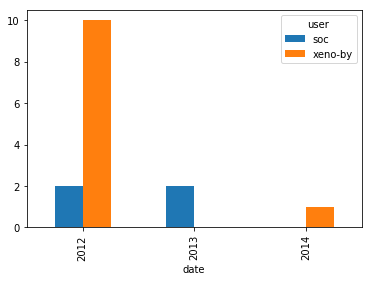

In [660]:
authors = ["xeno-by", "soc"]
file = "src/compiler/scala/reflect/reify/phases/Calculate.scala"

# Select the pull requests submitted by the authors
by_author = data[data["user"].isin(authors)]

# Select the pull requests that affect the file
by_file = by_author[by_author["file"] == file]

# Group and count the number of PRs done by each user each year
grouped = by_file.groupby(['user', by_file['date'].dt.year]).count()['pid'].reset_index()

# Transform the data into a wide format
by_file_wide = grouped.pivot_table(index="date", 
                                   columns="user", 
                                   values="pid",
                                   fill_value=0
                                  )
# Check
print(by_file_wide)

# Plot the results
by_file_wide.plot(kind='bar')